In [1]:
# Basics
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# TensorFlow/Keras (Keras layers below)
from tensorflow.keras.utils import set_random_seed, to_categorical
set_random_seed(1234) # set the seeds for Python, NumPy, and TensorFlow in order to reproduce the results

# Custom
import sys
sys.path.insert(0, '/home/lcastellazzi/MDM32/src/utils')
from preprocessing import TraceHandler
from nicv import nicv
import constants
from postprocessing import SingleByteEvaluator


# Suppress TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 1 for INFO, 2 for INFO & WARNINGs, 3 for INFO & WARNINGs & ERRORs

In [2]:
from tensorflow.keras.callbacks import EarlyStopping

import constants


def create_callbacks(es=True): # In future also other callbacks, for example the one to same the model in .h5 file
    callbacks = []
    
    if es:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=5))
        
    return callbacks

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

# from network_helpers import build_model, train_and_val_model, evaluate_model


class Network():
    
    def __init__(self, model_type, hp_choices):
        self._model_type = model_type
        self._hp_choices = hp_choices
        self._hp = {}
        self._model = Sequential()

    
    def get_hp(self, hp_name):
        return self._hp[hp_name]
    
    
    def set_hp(self, hp):
        self._hp = hp
        
        
    def select_random_hp(self):
        for hp_name in self._hp_choices:
            self._hp[hp_name] = random.choice(self._hp_choices[hp_name])
    
    
    def build_model(self):
        if self._model_type == 'MLP':
            # Input
            self._model.add(Dense(constants.TRACE_LEN, 
                            kernel_initializer=self._hp['kernel_initializer'], 
                            activation=self._hp['activation']))

            # First BatchNorm
            self._model.add(BatchNormalization())

            # Hidden
            for _ in range(self._hp['hidden_layers']):
                self._model.add(Dense(self._hp['hidden_neurons'], 
                                kernel_initializer=self._hp['kernel_initializer'], 
                                activation=self._hp['activation']))

                # Dropout
                self._model.add(Dropout(self._hp['dropout_rate']))

            # Second BatchNorm
            self._model.add(BatchNormalization())

            # Output
            self._model.add(Dense(256, activation='softmax')) ########################### 256 to be changed if the target is changed (HW, ...)

            # Compilation
            self._model.compile(optimizer=self._hp['optimizer'](learning_rate=self._hp['learning_rate']),
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])
        else:
            pass # In future there will be CNN
    
    
    def train_and_val(self, x_train, y_train, x_val, y_val):
        callbacks = create_callbacks()
    
        # Default train and validation (w.r.t accuracy)
        self._model.fit(x_train, 
                        y_train,
                        validation_data=(x_val, y_val),
                        epochs=100, # maybe as hp?
                        batch_size=100, # maybe as hp?
                        callbacks=callbacks,
                        verbose=1)
        
        # Evaluation of the model over the val data in order to have the overal val-performance (w.r.t. accuracy) 
        val_loss, val_acc = self._model.evaluate(x_val, 
                                                 y_val, 
                                                 verbose=0)
        return val_acc
    
    
    def final_train(self, x_train_tot, y_train_tot):
        
        # Default train and validation (w.r.t accuracy)
        self._model.fit(x_train_tot, 
                        y_train_tot,
                        epochs=100, # maybe as hp?
                        batch_size=100, # maybe as hp?
                        verbose=1)
        
    
    def plot_guessing_entropy(self, x_test, y_test, test_plaintexts, true_key_byte, byte_idx, n_exp=10):
        traces_per_exp = int(len(x_test) / n_exp)
        
        test_accs = []
        ranks = []
        for i in range(n_exp):
            start = i * traces_per_exp
            end = start + traces_per_exp

            test_loss, test_acc = self._model.evaluate(x_test, y_test, verbose=1)
            test_accs.append(test_acc)
            
            curr_preds = self._model.predict(x_test[start:end])

            curr_plaintexts = test_plaintexts[start:end]
            curr_evaluator = SingleByteEvaluator(test_plaintexts=curr_plaintexts,
                                                 byte_idx=byte_idx,
                                                 label_preds=curr_preds)
            curr_ranks = []
            for j in tqdm(range(traces_per_exp)):
                n_traces = j + 1
                curr_ranks.append(curr_evaluator.rank(true_key_byte, n_traces))

            curr_ranks = np.array(curr_ranks)
            ranks.append(curr_ranks)

        test_accs = np.array(test_accs)
        ranks = np.array(ranks)

        guessing_entropy = np.round(np.mean(ranks, axis=0)) # .5 approximated to the next int

        f, ax = plt.subplots(2, 1, figsize=(10, 15))
        
        ax[0].plot(test_accs, color='r')
        ax[0].set_title('Test acc')
        ax[0].grid()
        
        ax[1].plot(guessing_entropy[:50], color='b', marker='o')
        ax[1].set_title('Guessing Entropy')
        ax[1].grid()
        
        plt.show()

In [4]:
import random

class GeneticTuner():
    
    def __init__(self, hp_choices, model_type='MLP', pop_size=10, selection_perc=0.5, mutation_chance=0.2):
        self._model_type = model_type
        self._pop_size = pop_size
        self._hp_choices = hp_choices
        self._selection_perc = selection_perc
        self._mutation_chance = mutation_chance
    
    
    def populate(self):
        pop = []
        for _ in range(self._pop_size):
            individual = Network(self._model_type, self._hp_choices)
            individual.select_random_hp()
            pop.append(individual)
            
        return pop
    
        
    def evaluate(self, pop, x_train, y_train, x_val, y_val):
        
        fitness_values = []
        for i, individual in enumerate(pop):
            print()
            print(f'***** Individual {i+1}/{self._pop_size} *****')
            
            individual.build_model()
            val_acc = individual.train_and_val(x_train, y_train, x_val, y_val) # Default train and val w.r.t. accuracy
            fitness_values.append(val_acc) 
        
        evaluation = list(zip(pop, fitness_values))
        
        return evaluation
    
    
    def select(self, evaluation):
        num_selected = int(self._selection_perc * self._pop_size)
        evaluation.sort(key=lambda x: -x[1]) # Sort the individuals w.r.t. their accuracy (the higher the better, so the "-" is needed)
        sorted_pop = [individual for individual, _ in evaluation]
        parents = sorted_pop[:num_selected]
        
        return parents
        
    
    def _produce_offspring(self, parentA, parentB):
        # An offspring contains hps from both parents (random selection)
        offspring_hp = {hp_name: random.choice([parentA.get_hp(hp_name), parentA.get_hp(hp_name)]) 
                        for hp_name in self._hp_choices}
        
        return offspring_hp
        
    
    def _mutate_offspring(self, offspring_hp):
        # A mutation is a random hp from the possible choices
        to_mutate = random.choice(list(self._hp_choices.keys()))
        offspring_hp[to_mutate] = random.choice(self._hp_choices[to_mutate])
        
        return offspring_hp
    
    
    def evolve(self, parents):
        # Only the individuals with the best performances are kept and used to generate offsprings
        # The size of the population is the same
        num_offsprings = self._pop_size - len(parents)
        
        offsprings = []
        for _ in range(num_offsprings):
            parentA, parentB = random.sample(parents, k=2)
            offspring_hp = self._produce_offspring(parentA, parentB)
            
            if self._mutation_chance > random.random():
                offspring_hp = self._mutate_offspring(offspring_hp)
            
            offspring = Network(self._model_type, self._hp_choices)
            offspring.set_hp(offspring_hp)
            
            offsprings.append(offspring)
            
        new_pop = parents + offsprings
        
        return new_pop

# --------------------------------------------------------------------------------------------

In [5]:
train_th = TraceHandler('/prj/side_channel/PinataTraces/CURR/D1-K1_50k_500MHz + Resampled at 168MHz.trs')

BYTE_IDX = 0
N_CLASSES = 256
VAL_PERC = 0.1

x_train_tot = train_th.get_traces()
y_train_tot = train_th.get_specific_labels(BYTE_IDX)
y_train_tot = to_categorical(y_train_tot, N_CLASSES)

x_train, x_val, y_train, y_val = train_th.generate_train_val(BYTE_IDX, val_perc=VAL_PERC)
y_train = to_categorical(y_train, N_CLASSES)
y_val = to_categorical(y_val, N_CLASSES)

Labeling traces: 100%|██████████| 50000/50000 [00:21<00:00, 2301.58it/s]


In [6]:
from tensorflow.keras.optimizers import Adam, RMSprop

HP_CHOICES = {'kernel_initializer': ['random_normal', 'he_normal'],
              'activation':         ['relu', 'tanh'],
              'hidden_layers':      [1, 2, 3, 4, 5],
              'hidden_neurons':     [100, 200, 300, 400, 500],
              'dropout_rate':       [0.0, 0.2, 0.4],
              'optimizer':          [Adam, RMSprop],
              'learning_rate':      [1e-3, 1e-4, 1e-5]}  

In [7]:
GENERATIONS = 2

gt = GeneticTuner(hp_choices=HP_CHOICES, pop_size=6)
population = gt.populate()

for i in range(GENERATIONS):
    print()
    print(f'-------------------- Generation {i+1}/{GENERATIONS} --------------------')
    
    evaluation = gt.evaluate(population, x_train, y_train, x_val, y_val) # list of tuple Network-val_acc
    
    parents = gt.select(evaluation) # list of Network objects
    
    if i != GENERATIONS - 1:
        population = gt.evolve(parents) # list of Network objects
    
    print()
    print(f'Generation {i+1}/{GENERATIONS} Evaluation: {[ev[1] for ev in evaluation]}')


-------------------- Generation 1/2 --------------------

***** Individual 1/6 *****
Epoch 1/100
450/450 [==============================] - 1s 2ms/step - loss: 5.8055 - accuracy: 0.0044 - val_loss: 5.6721 - val_accuracy: 0.0048
Epoch 2/100
450/450 [==============================] - 1s 2ms/step - loss: 5.7645 - accuracy: 0.0052 - val_loss: 5.6583 - val_accuracy: 0.0040
Epoch 3/100
450/450 [==============================] - 1s 2ms/step - loss: 5.7286 - accuracy: 0.0052 - val_loss: 5.6286 - val_accuracy: 0.0070
Epoch 4/100
450/450 [==============================] - 1s 2ms/step - loss: 5.7005 - accuracy: 0.0055 - val_loss: 5.6086 - val_accuracy: 0.0062
Epoch 5/100
450/450 [==============================] - 1s 2ms/step - loss: 5.6661 - accuracy: 0.0069 - val_loss: 5.5813 - val_accuracy: 0.0072
Epoch 6/100
450/450 [==============================] - 1s 2ms/step - loss: 5.6377 - accuracy: 0.0083 - val_loss: 5.5572 - val_accuracy: 0.0072
Epoch 7/100
450/450 [==============================] - 1

In [8]:
evaluation.sort(key=lambda x: -x[1])

best_individual, best_val_acc = evaluation[0]

print(f'Best val_acc: {best_val_acc}')

Best val_acc: 0.09019999951124191


In [9]:
test_th = TraceHandler('/prj/side_channel/PinataTraces/CURR/D1-K2_50k_500MHz + Resampled at 168MHz.trs')

x_test, y_test = test_th.generate_test(BYTE_IDX) 
y_test = to_categorical(y_test, N_CLASSES)

test_plaintexts = test_th.get_plaintexts()
true_key_byte = test_th.get_key()[BYTE_IDX]

Labeling traces: 100%|██████████| 50000/50000 [00:21<00:00, 2306.44it/s]


In [10]:
x_train_tot = train_th.get_traces()
y_train_tot = train_th.get_specific_labels(BYTE_IDX)
y_train_tot = to_categorical(y_train_tot, N_CLASSES)

best_individual.final_train(x_train_tot, y_train_tot)

Epoch 1/100
500/500 [==============================] - 1s 2ms/step - loss: 3.0110 - accuracy: 0.2353
Epoch 2/100
500/500 [==============================] - 1s 2ms/step - loss: 2.9553 - accuracy: 0.2442
Epoch 3/100
500/500 [==============================] - 1s 2ms/step - loss: 2.9291 - accuracy: 0.2493
Epoch 4/100
500/500 [==============================] - 1s 2ms/step - loss: 2.8910 - accuracy: 0.2545
Epoch 5/100
500/500 [==============================] - 1s 2ms/step - loss: 2.8590 - accuracy: 0.2606
Epoch 6/100
500/500 [==============================] - 1s 2ms/step - loss: 2.8365 - accuracy: 0.2652
Epoch 7/100
500/500 [==============================] - 1s 2ms/step - loss: 2.8104 - accuracy: 0.2694
Epoch 8/100
500/500 [==============================] - 1s 2ms/step - loss: 2.7686 - accuracy: 0.2795
Epoch 9/100
500/500 [==============================] - 1s 2ms/step - loss: 2.7360 - accuracy: 0.2848
Epoch 10/100
500/500 [==============================] - 1s 2ms/step - loss: 2.6863 - accura

1563/1563 [==============================] - 2s 1ms/step - loss: 9.6088 - accuracy: 0.0555


100%|██████████| 5000/5000 [00:18<00:00, 275.91it/s] 


1563/1563 [==============================] - 2s 1ms/step - loss: 9.6088 - accuracy: 0.0555


100%|██████████| 5000/5000 [00:18<00:00, 275.83it/s] 


1563/1563 [==============================] - 2s 1ms/step - loss: 9.6088 - accuracy: 0.0555


100%|██████████| 5000/5000 [00:17<00:00, 279.30it/s] 


1563/1563 [==============================] - 2s 1ms/step - loss: 9.6088 - accuracy: 0.0555


100%|██████████| 5000/5000 [00:17<00:00, 279.27it/s] 


1563/1563 [==============================] - 2s 1ms/step - loss: 9.6088 - accuracy: 0.0555


100%|██████████| 5000/5000 [00:18<00:00, 276.35it/s] 


1563/1563 [==============================] - 2s 1ms/step - loss: 9.6088 - accuracy: 0.0555


100%|██████████| 5000/5000 [00:18<00:00, 276.69it/s] 


1563/1563 [==============================] - 2s 1ms/step - loss: 9.6088 - accuracy: 0.0555


100%|██████████| 5000/5000 [00:18<00:00, 276.32it/s] 


1563/1563 [==============================] - 2s 1ms/step - loss: 9.6088 - accuracy: 0.0555


100%|██████████| 5000/5000 [00:18<00:00, 275.25it/s] 


1563/1563 [==============================] - 2s 1ms/step - loss: 9.6088 - accuracy: 0.0555


100%|██████████| 5000/5000 [00:18<00:00, 275.69it/s] 


1563/1563 [==============================] - 2s 1ms/step - loss: 9.6088 - accuracy: 0.0555


100%|██████████| 5000/5000 [00:18<00:00, 275.90it/s] 


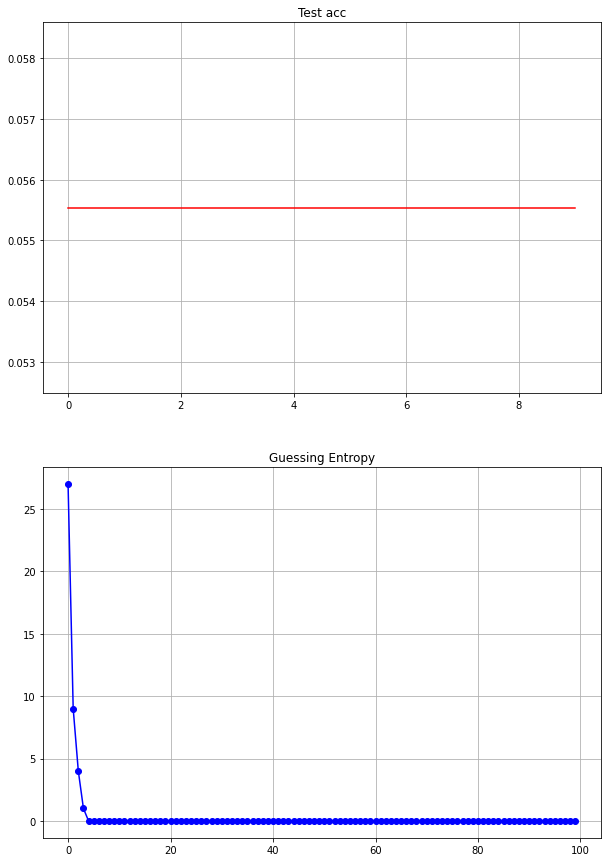

In [11]:
best_individual.plot_guessing_entropy(x_test, y_test, test_plaintexts, true_key_byte, BYTE_IDX)